# Transfer Learning with tensorflow:
## Part 1 Feature Extraction


---

The main benefits of using transfer learning:
1. Can leverage existing neural networks that have been proven to work 
2. Can leverage a working neural network architecture which has already learned patterns with similar data to our own.

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import pathlib
import zipfile
import os
import random
import datetime

### Download data

In [2]:
# Download 10 percent of the 10 food classes dataset
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip downloaded data
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-01-08 16:06:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   103MB/s    in 1.6s    

2022-01-08 16:06:14 (103 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images are there in each folder
for dirpath,dirnames, filenames in os.walk('/content/10_food_classes_10_percent'):
  if len(dirnames) == 0:
    print(f"There are {len(filenames)} images in {dirpath} ")
  else:
    print(f"There are {len(dirnames)} directories in {dirpath}")

There are 2 directories in /content/10_food_classes_10_percent
There are 10 directories in /content/10_food_classes_10_percent/train
There are 75 images in /content/10_food_classes_10_percent/train/grilled_salmon 
There are 75 images in /content/10_food_classes_10_percent/train/pizza 
There are 75 images in /content/10_food_classes_10_percent/train/hamburger 
There are 75 images in /content/10_food_classes_10_percent/train/chicken_curry 
There are 75 images in /content/10_food_classes_10_percent/train/ice_cream 
There are 75 images in /content/10_food_classes_10_percent/train/fried_rice 
There are 75 images in /content/10_food_classes_10_percent/train/ramen 
There are 75 images in /content/10_food_classes_10_percent/train/chicken_wings 
There are 75 images in /content/10_food_classes_10_percent/train/sushi 
There are 75 images in /content/10_food_classes_10_percent/train/steak 
There are 10 directories in /content/10_food_classes_10_percent/test
There are 250 images in /content/10_food

In [4]:
# Get the subdirectories (class_names)
data_dir = pathlib.Path('10_food_classes_10_percent/train')
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [5]:
# Function to view random images
def view_random_image(target_dir,target_class):
  """
  Gets a random image from a selected directory and calss
  """
  target_folder = target_dir + "/" + target_class
  random_image = random.sample(os.listdir(target_folder),1)

  # Plot out the image
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape: {img.shape}")
  
  return img

In [6]:
# Plot a random image for each class
def view_images(target_dir):
  """
  Plots a random image from each class
  """
  plt.figure(figsize=(15,15))
  for i in range(len(class_names)):
    plt.subplot(5,5,i+1)
    target_folder = target_dir + "/" + class_names[i]
    random_image = random.sample(os.listdir(target_folder),1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.axis("off")
    img_info = class_names[i] + "\n" + str(img.shape)
    plt.title(img_info)

Image shape: (384, 512, 3)


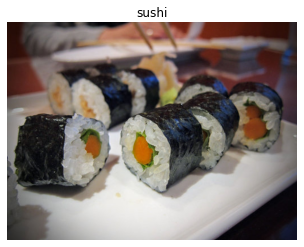

In [7]:
img = view_random_image(target_dir = '10_food_classes_10_percent/test',
                        target_class = 'sushi')

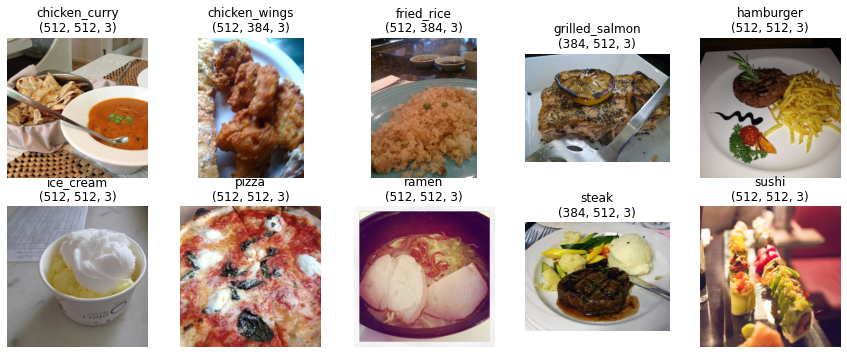

In [8]:
view_images(target_dir = "10_food_classes_10_percent/train")

## Creating data loaders (preparing the data)
we will prepare the data using tf keras ImageDataGenerator

In [9]:
# Setup global variables
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5


# Setup data
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")


test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Setting up callbacks
Call can be used for
* Tracking experiments with tensorboard
* Model checkpoint
* Stopping a model from overtraining


In [10]:
# Create tensorboard callback 
# We wil make it into a function in order to use it for multiple models

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%d-%m-%Y|%H:%M")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating the model using tensorflow hub
We are going to use and compare 2 models


In [11]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficient_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [12]:
# Lets make a function to create a model from a url
def create_model(model_url,num_classes=10):
  """
  Creates a keras model from a tfhub url
  Also gets number of classes needed ,default = 10
  
  Retruns:
    An uncompiled Keras sequential model with model_ulr as feature extractor layer
    and Dense output layer with num classes output neurons
  """
  # Download the pretained model and save it as a kera layers
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes,activation="softmax",name="Output_layer")
  ])


  return model


In [13]:
# Create model
resnet_model = create_model(resnet_url)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [14]:
# Lets fit the model to the data
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/08-01-2022|16:06
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 2.0245 - accuracy: 0.3253 - val_loss: 1.2652 - val_accuracy: 0.6052
Epoch 2/5
24/24 [==============================] - 23s 1s/step - loss: 0.9570 - accuracy: 0.7213 - val_loss: 0.8735 - val_accuracy: 0.7176
Epoch 3/5
24/24 [==============================] - 22s 959ms/step - loss: 0.6489 - accuracy: 0.8213 - val_loss: 0.7594 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 23s 963ms/step - loss: 0.4892 - accuracy: 0.8813 - val_loss: 0.7081 - val_accuracy: 0.7760
Epoch 5/5
24/24 [==============================] - 22s 958ms/step - loss: 0.3892 - accuracy: 0.9200 - val_loss: 0.6750 - val_accuracy: 0.7872


In [15]:
def plot_loss_curves(history):
  """
  Plots out separate loss curves for training and validation data
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot the loss
  plt.plot(epochs,loss,label="training loss")
  plt.plot(epochs,val_loss,label= "validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot out the accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="Training accuracy")
  plt.plot(epochs,val_accuracy,label="Validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


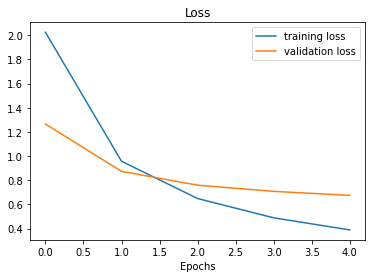

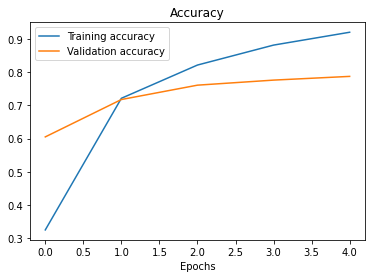

In [16]:
plot_loss_curves(resnet_history)

## Time to try again this time with the efficient net b0 feature extraction model

In [17]:
# Create and compile model
efficientnet_model = create_model(efficient_url)


efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [18]:
# Lets fit the model to the data
efficient_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="efficientnet")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/efficientnet/08-01-2022|16:08
Epoch 1/5
24/24 [==============================] - 33s 900ms/step - loss: 1.7611 - accuracy: 0.4933 - val_loss: 1.2375 - val_accuracy: 0.7508
Epoch 2/5
24/24 [==============================] - 19s 806ms/step - loss: 1.0113 - accuracy: 0.7827 - val_loss: 0.8341 - val_accuracy: 0.8212
Epoch 3/5
24/24 [==============================] - 19s 805ms/step - loss: 0.7277 - accuracy: 0.8400 - val_loss: 0.6769 - val_accuracy: 0.8472
Epoch 4/5
24/24 [==============================] - 19s 810ms/step - loss: 0.5863 - accuracy: 0.8693 - val_loss: 0.5954 - val_accuracy: 0.8572
Epoch 5/5
24/24 [==============================] - 19s 811ms/step - loss: 0.4984 - accuracy: 0.8907 - val_loss: 0.5435 - val_accuracy: 0.8632


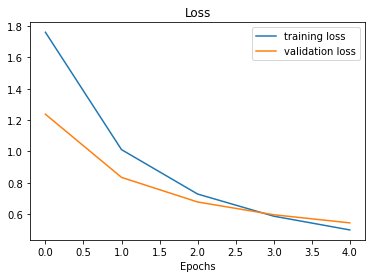

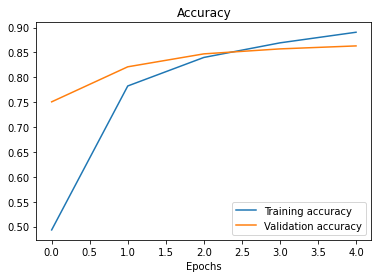

In [19]:
plot_loss_curves(efficient_history)

In [27]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 Output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [29]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 Output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________
